In [11]:
import gpytorch
import torch
from itertools import product
import matplotlib.pyplot as plt

In [12]:
def plot_2d_gp(model, likelihood, x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, resolution=50):
    xx, yy = torch.meshgrid(
        torch.linspace(x_min, x_max, resolution), 
        torch.linspace(y_min, y_max, resolution)
    )
    test_x = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=-1)

    model.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = likelihood(model(test_x))
        mean = preds.mean.reshape(resolution, resolution)
        lower, upper = preds.confidence_region()
        lower = lower.reshape(resolution, resolution)
        upper = upper.reshape(resolution, resolution)

    plt.figure()
    mean_contour = plt.contourf(xx.numpy(), yy.numpy(), mean.numpy(), levels=50, cmap='viridis')
    plt.colorbar(mean_contour, label='Mean')
    plt.contour(xx.numpy(), yy.numpy(), lower.numpy(), levels=10, linestyles='dotted', colors='white', alpha=0.7)
    plt.contour(xx.numpy(), yy.numpy(), upper.numpy(), levels=10, linestyles='dashed', colors='white', alpha=0.7)
    plt.title('2D GP Mean and Variance')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

In [13]:
def plot_3d_gp(model, likelihood, x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, resolution=50):

    model.eval()
    likelihood.eval()

    x_vals = torch.linspace(x_min, x_max, resolution)
    y_vals = torch.linspace(y_min, y_max, resolution)
    xx, yy = torch.meshgrid(x_vals, y_vals)
    test_x = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=-1)

    with torch.no_grad():
        preds = likelihood(model(test_x))
        mean = preds.mean.reshape(resolution, resolution)
        lower, upper = preds.confidence_region()
        lower = lower.reshape(resolution, resolution)
        upper = upper.reshape(resolution, resolution)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot mean surface
    ax.plot_surface(xx.numpy(), yy.numpy(), mean.numpy(), cmap='viridis', alpha=0.8)

    # Plot lower and upper surfaces
    ax.plot_surface(xx.numpy(), yy.numpy(), lower.numpy(), color='gray', alpha=0.2)
    ax.plot_surface(xx.numpy(), yy.numpy(), upper.numpy(), color='gray', alpha=0.2)

    ax.set_title('2D GP in 3D')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Mean and Variance Range')

    plt.show()


In [14]:
def plot_3d_gp_samples(samples, xx, yy):
    """
    Visualize multiple samples drawn from a 2D-input (xx, yy) -> 1D-output GP in 3D.
    Each sample in 'samples' should be a 1D tensor that can be reshaped to match xx, yy.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i, sample in enumerate(samples):
        z_vals = sample.reshape(xx.shape)
        ax.plot_surface(xx.numpy(), yy.numpy(), z_vals.numpy(), alpha=0.4)

    ax.set_title('GP Samples in 3D')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')
    plt.show()

In [15]:
class ExactMIGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel_text="RBF", weights=None):
        super(ExactMIGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.AdditiveStructureKernel(gpytorch.kernels.RBFKernel(active_dims=0) + gpytorch.kernels.MaternKernel(active_dims=1), num_dims=2)

    def forward(self, x):
        mean_x = self.mean_module(x)#sum([self.mean_module(xp) for xp in x])
        covar_x = self.covar_module(x)#sum([covar(xp) for xp, covar in zip(x, self.covar_module)])
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [19]:
X_SIZE = 3 

# data MUST be pairs of x_i values i.e. (x1, x2), (x1, x3), (x2, x3), etc.
train_x = torch.tensor(list(product(torch.linspace(0, 5, X_SIZE), torch.linspace(0, 5, X_SIZE))))
print(train_x)
train_y = (torch.sin(train_x[:,0]) + torch.cos(train_x[:,1]))#.view(-1, 1)
data_likelihood = gpytorch.likelihoods.GaussianLikelihood()
data_model = ExactMIGPModel(train_x, train_y, data_likelihood)

tensor([[0.0000, 0.0000],
        [0.0000, 2.5000],
        [0.0000, 5.0000],
        [2.5000, 0.0000],
        [2.5000, 2.5000],
        [2.5000, 5.0000],
        [5.0000, 0.0000],
        [5.0000, 2.5000],
        [5.0000, 5.0000]])


In [40]:
test_size = 50 
observations_x = torch.tensor(list(product(torch.linspace(0, 5, test_size), torch.linspace(0, 5, test_size))))

x_vals = torch.linspace(0, 5, test_size)
y_vals = torch.linspace(0, 5, test_size)
xx, yy = torch.meshgrid(x_vals, y_vals)
test_x = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=-1)# Get into evaluation (predictive posterior) mode
data_model.eval()
data_likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.prior_mode(True):
    f_preds = data_model(test_x)

all_observations_y = f_preds.sample_n(4)

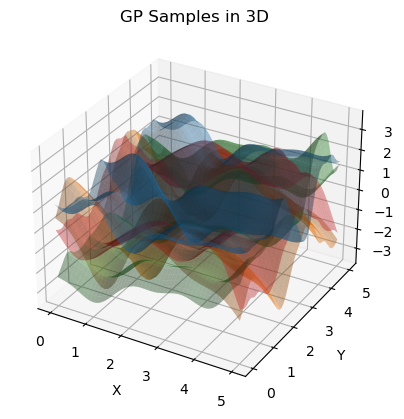

In [41]:
plot_3d_gp_samples(all_observations_y, xx, yy)

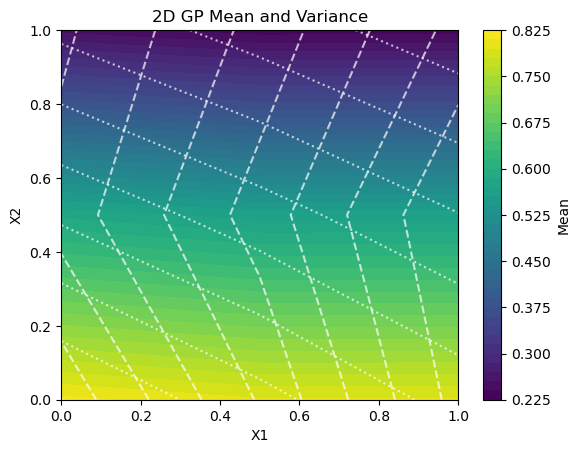

In [29]:
plot_2d_gp(data_model, data_likelihood, x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, resolution=3)

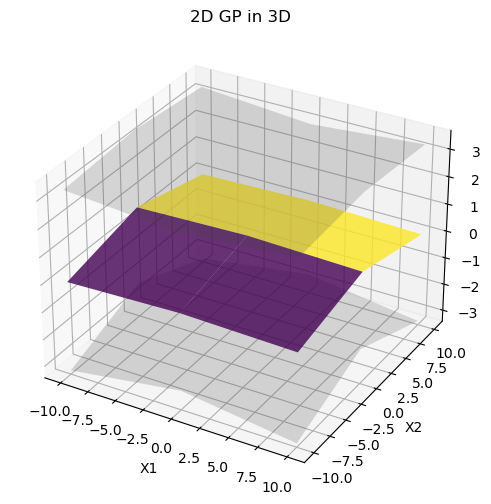

In [30]:
plot_3d_gp(data_model, data_likelihood, x_min=-10.0, x_max=10.0, y_min=-10.0, y_max=10.0, resolution=3)